# **PLANO DE SAÚDE: GRADIENT BOOSTING**



### Instalação de bibliotecas

In [ ]:
# As bibliotecas utilizadas neste notebook já vêm pré-instaladas no Google Colab

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler         # Balanceamento de classes
from sklearn import ensemble                                   # Gradient boosting
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search

### Leitura da base de dados

In [ ]:
dados_plano = pd.read_table("Plano_Saude.txt", sep = "\t")

In [ ]:
# Reordenação de categorias da variável resposta
dados_plano['STATUS'] = pd.Categorical(dados_plano['STATUS'], categories = ['CancInvol', 'CancVol', 'Down', 'Mantem', 'Up'], ordered = True)

### Visualização da base de dados

In [ ]:
display(dados_plano)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Separação de features e target

In [ ]:
X = dados_plano.drop(columns = ['STATUS', 'ID_CLIENTE'])
y = dados_plano['STATUS']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
X = pd.get_dummies(X, drop_first = True)

### Balanceamento de base de dados (undersampling) e redução do tamanho da amostra, se necessário
##### Caso haja forte desbalanceamento entre as frequências das categorias da variável *target*, o balanceamento pode ajudar a proporcionar maior taxa de acerto em categorias minoritárias. Caso a base de dados seja grande mesmo após undersampling, pode-se selecionar uma sub-amostra ainda menor, para acelerar o processamento.

In [ ]:
# Contagem de valores na variável resposta antes do balanceamento/redução
y.value_counts()

,count
STATUS,
Mantem,67000
Up,13000
Down,10000
CancInvol,6000
CancVol,4000


In [ ]:
# Balanceamento de base de dados via undersampling; caso seja necessário reduzir ainda mais o tamanho da amostra, escolha os tamanhos no argumento 'sampling_strategy'
rus = RandomUnderSampler(sampling_strategy = {'CancInvol': 2000, 'CancVol': 2000, 'Down': 2000, 'Mantem': 2000, 'Up': 2000}, random_state = 123)
X_sample, y_sample = rus.fit_resample(X, y)

In [ ]:
# Contagem de valores na variável resposta após o balanceamento/redução
y_sample.value_counts()

,count
STATUS,
CancInvol,2000
CancVol,2000
Down,2000
Mantem,2000
Up,2000


### Modelo 1: gradient boosting com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_samples_leaf': np.arange(100, 1001)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC-OVR e k = 5 (EXECUÇÃO ONEROSA)
gradboost = ensemble.GradientBoostingClassifier(random_state = 123)
cv = KFold(n_splits = 5, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(gradboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
random_search.fit(X_sample, y_sample)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=123),
                   n_iter=100,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.3...
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC_OVR',
                   scoring={'AUC_OVR': 'roc_auc_ovr',
                            'balanced_accuracy': 'balanced_accuracy'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 160, 'min_samples_leaf': 426, 'max_depth': 2, 'learning_rate': 0.2}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
8,"{'n_estimators': 160, 'min_samples_leaf': 426,...",0.904873,0.004444,1,0.657302,0.011195,5
42,"{'n_estimators': 50, 'min_samples_leaf': 272, ...",0.903963,0.004296,2,0.659080,0.013991,1
2,"{'n_estimators': 150, 'min_samples_leaf': 382,...",0.903935,0.004468,3,0.657459,0.011590,4
22,"{'n_estimators': 120, 'min_samples_leaf': 366,...",0.903870,0.004705,4,0.657822,0.012369,2
54,"{'n_estimators': 40, 'min_samples_leaf': 425, ...",0.903832,0.004099,5,0.655843,0.010655,6
...,...,...,...,...,...,...,...
81,"{'n_estimators': 110, 'min_samples_leaf': 1000...",0.878466,0.003408,96,0.608102,0.008734,97
93,"{'n_estimators': 150, 'min_samples_leaf': 137,...",0.877522,0.004382,97,0.611586,0.009150,94
23,"{'n_estimators': 180, 'min_samples_leaf': 409,...",0.877421,0.004103,98,0.605760,0.013007,98
82,"{'n_estimators': 10, 'min_samples_leaf': 577, ...",0.873993,0.003206,99,0.601763,0.009600,99


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
gradboost_1 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_samples_leaf': np.arange(100, 1001)
}

In [ ]:
# Validação cruzada estratificada aninhada com random search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
gradboost = ensemble.GradientBoostingClassifier(random_state = 123)
inner_cv = KFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(gradboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X_sample, y = y_sample, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.905 0.901 0.897 0.909 0.906]
Média de AUC-OVR: 0.904
D.P. de AUC-OVR: 0.004


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.663 0.661 0.635 0.66  0.666]
Média de Acurácia Balanceada: 0.657
D.P. de Acurácia Balanceada: 0.011


### Aplicação do modelo final de gradient boosting na base de dados



In [ ]:
# Atribuição das probabilidades preditas por categoria
gradboost_1.fit(X, y)
y_prob = pd.DataFrame(gradboost_1.predict_proba(X)[:,:], columns = gradboost_1.classes_)
dados_plano = pd.concat([dados_plano, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
dados_plano['y_pred'] = gradboost_1.predict(X)

In [ ]:
# Matriz de classificação absoluta: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'])

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,3428,277,214,2061,20
CancVol,422,1851,351,1364,12
Down,279,445,3144,6106,26
Mantem,839,396,1297,62348,2120
Up,53,15,18,7962,4952


In [ ]:
# Matriz de classificação relativa: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'], normalize = 'index').round(2)

### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = gradboost_1.feature_importances_
features = X.columns

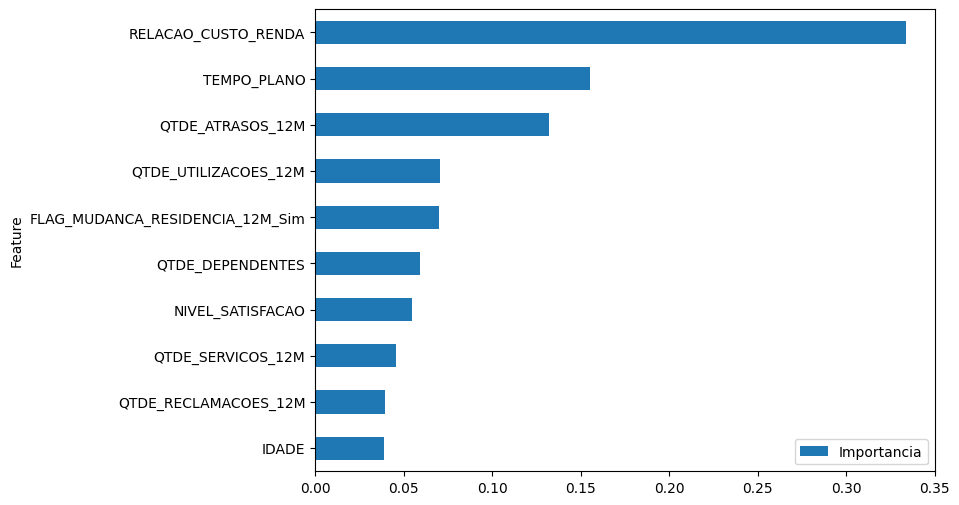

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações: NÃO IMPLEMENTADO PARA GRADIENT BOOSTING NA BIBLIOTECA 'SHAP' NO CASO MULTINOMIAL, APENAS BINÁRIO